#Achieving Generalization

##Testing and cross-validation

###Train-test split

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston() 
dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
dataset['target'] = boston.target
observations = len(dataset)
variables = dataset.columns[:-1]
X = dataset.ix[:,:-1]
y = dataset['target'].values

In [2]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
print ("Train dataset sample size: %i" % len(X_train))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 354
Test dataset sample size: 152


In [3]:
X_train, X_out_sample, y_train, y_out_sample = train_test_split(X, y, test_size=0.40, random_state=101)
X_validation, X_test, y_validation, y_test = train_test_split(X_out_sample, y_out_sample, test_size=0.50, random_state=101)
print ("Train dataset sample size: %i" % len(X_train))
print ("Validation dataset sample size: %i" % len(X_validation))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 303
Validation dataset sample size: 101
Test dataset sample size: 102


###Cross validation

In [4]:
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

def RMSE(y_true, y_pred):
    return np.sum((y_true -y_pred)**2)

lm = LinearRegression()
cv_iterator = KFold(n=len(X), n_folds=10, shuffle=True, random_state=101)

edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)
stratified_cv_iterator = StratifiedKFold(binning, n_folds=10, shuffle=True, random_state=101)

second_order=PolynomialFeatures(degree=2, interaction_only=False)
third_order=PolynomialFeatures(degree=3, interaction_only=True)

over_param_X = second_order.fit_transform(X)
extra_over_param_X = third_order.fit_transform(X)
cv_score = cross_val_score(lm, over_param_X, y, cv=cv_iterator, scoring='mean_squared_error', n_jobs=1)

In [5]:
print (cv_score)

[-10.79792467 -19.21944292  -8.39077691 -14.79808458 -10.90565129
  -7.08445784 -12.8788423  -16.80309722 -32.40034131 -13.66625192]


In [6]:
print ('Cv score: mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score: mean 14.694 std 6.855


In [7]:
cv_score = cross_val_score(lm, over_param_X, y, cv=stratified_cv_iterator, scoring='mean_squared_error', n_jobs=1)
print ('Cv score: mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score: mean 13.584 std 5.226


Valid options are ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc'

http://scikit-learn.org/stable/modules/model_evaluation.html

###Bootstrapping

In [8]:
import random
def Bootstrap(n, n_iter=3, random_state=None):
    """
    Random sampling with replacement cross-validation generator.
    For each iter a sample bootstrap of the indexes [0, n) is
    generated and the function returns the obtained sample
    and a list of all the excluded indexes.
    """
    if random_state:
        random.seed(random_state)
    for j in range(n_iter):
        bs = [random.randint(0, n-1) for i in range(n)]
        out_bs = list({i for i in range(n)} - set(bs))
        yield bs, out_bs
        
boot = Bootstrap(n=10, n_iter=5, random_state=101)
for train_idx, validation_idx in boot:
    print (train_idx, validation_idx)

[9, 3, 8, 5, 7, 0, 8, 3, 9, 3] [1, 2, 4, 6]
[4, 7, 3, 5, 7, 1, 4, 3, 2, 1] [0, 8, 9, 6]
[7, 8, 5, 3, 7, 5, 3, 6, 6, 3] [0, 1, 2, 9, 4]
[1, 6, 7, 4, 3, 1, 9, 5, 4, 6] [0, 8, 2]
[6, 3, 6, 1, 6, 6, 0, 7, 3, 8] [9, 2, 4, 5]


In [9]:
import numpy as np
boot = Bootstrap(n=len(X), n_iter=10, random_state=101)
lm = LinearRegression()
bootstrapped_coef = np.zeros((10,13))
for k, (train_idx, validation_idx) in enumerate(boot):
    lm.fit(X.ix[train_idx,:],y[train_idx])
    bootstrapped_coef[k,:] = lm.coef_

In [10]:
print(bootstrapped_coef[:,10])

[-1.04150741 -0.93651754 -1.09205904 -1.10422447 -0.9982515  -0.79789273
 -0.89421685 -0.92320895 -1.0276369  -0.79189224]


In [11]:
print(bootstrapped_coef[:,6])

[-0.01930727  0.00053026 -0.00026774  0.00607945  0.02225979 -0.00089469
  0.01922754  0.02164681  0.01243348 -0.02693115]


##Greedy selection of features 

###Controlling for over-parameterization

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
lm = LinearRegression()
lm.fit(X_train,y_train)
print ('Train (cases, features) = %s' % str(X_train.shape))
print ('Test  (cases, features) = %s' % str(X_test.shape))
print ('In-sample  mean squared error %0.3f' % mean_squared_error(y_train,lm.predict(X_train)))
print ('Out-sample mean squared error %0.3f' % mean_squared_error(y_test,lm.predict(X_test)))

Train (cases, features) = (354, 13)
Test  (cases, features) = (152, 13)
In-sample  mean squared error 22.420
Out-sample mean squared error 22.440


In [13]:
from sklearn.preprocessing import PolynomialFeatures
second_order=PolynomialFeatures(degree=2, interaction_only=False)
third_order=PolynomialFeatures(degree=3, interaction_only=True)

In [14]:
lm.fit(second_order.fit_transform(X_train),y_train)
print ('(cases, features) = %s' % str(second_order.fit_transform(X_train).shape))
print ('In-sample  mean squared error %0.3f' % mean_squared_error(y_train,lm.predict(second_order.fit_transform(X_train))))
print ('Out-sample mean squared error %0.3f' % mean_squared_error(y_test,lm.predict(second_order.fit_transform(X_test))))

(cases, features) = (354, 105)
In-sample  mean squared error 5.579
Out-sample mean squared error 12.034


In [15]:
lm.fit(third_order.fit_transform(X_train),y_train)
print ('(cases, features) = %s' % str(third_order.fit_transform(X_train).shape))
print ('In-sample  mean squared error %0.3f' % mean_squared_error(y_train,lm.predict(third_order.fit_transform(X_train))))
print ('Out-sample mean squared error %0.3f' % mean_squared_error(y_test,lm.predict(third_order.fit_transform(X_test))))

(cases, features) = (354, 378)
In-sample  mean squared error 0.438
Out-sample mean squared error 85781.479


###Madelon dataset

In [16]:
try:
    import urllib.request as urllib2 
except:
    import urllib2 
import numpy as np
train_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
validation_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_valid.data'
train_response = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'
validation_response = 'https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/madelon_valid.labels'
try:
    Xt = np.loadtxt(urllib2.urlopen(train_data))
    yt = np.loadtxt(urllib2.urlopen(train_response))
    Xv = np.loadtxt(urllib2.urlopen(validation_data))
    yv = np.loadtxt(urllib2.urlopen(validation_response))
except:
    # In case downloading the data doesn't works, 
    # just manually download the files into the working directory
    Xt = np.loadtxt('madelon_train.data')
    yt = np.loadtxt('madelon_train.labels')
    Xv = np.loadtxt('madelon_valid.data')
    yv = np.loadtxt('madelon_valid.labels')

In [17]:
print ('Training set: %i observations %i feature' % (Xt.shape))
print ('Validation set: %i observations %i feature' % (Xv.shape))

Training set: 2000 observations 500 feature
Validation set: 600 observations 500 feature


In [18]:
from scipy.stats import describe
print (describe(Xt))

DescribeResult(nobs=2000, minmax=(array([ 462.,  381.,  370.,  453.,  371.,  459.,  334.,  471.,  430.,
        455.,  354.,  389.,  347.,  352.,  444.,  410.,  433.,  377.,
        408.,  441.,  426.,  412.,  456.,  438.,  343.,  416.,  421.,
        441.,  438.,  417.,  451.,  382.,  369.,  363.,  384.,  342.,
        441.,  396.,  464.,  471.,  463.,  362.,  392.,  438.,  406.,
        392.,  371.,  373.,  367.,  382.,  381.,  382.,  399.,  465.,
        401.,  409.,  288.,  377.,  378.,  408.,  400.,  462.,  377.,
        458.,  214.,  385.,  373.,  395.,  462.,  452.,  362.,  427.,
        402.,  354.,  456.,  371.,  446.,  396.,  379.,  424.,  415.,
        385.,  396.,  430.,  372.,  391.,  458.,  406.,  454.,  377.,
        474.,  395.,  399.,  438.,  452.,  384.,  468.,  406.,  412.,
        355.,  448.,  448.,  460.,  428.,  361.,    0.,  349.,  370.,
        391.,  442.,  392.,  356.,  450.,  385.,  353.,  413.,  418.,
        441.,  389.,  414.,  469.,  380.,  437.,  355., 

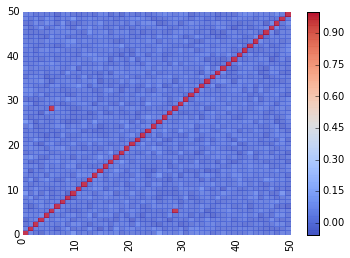

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def visualize_correlation_matrix(data, hurdle = 0.0):
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', left = 'off', 
    right = 'off') 
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(Xt[:,100:150], hurdle=0.0)

In [20]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

In [21]:
logit = LogisticRegression()

In [22]:
logit.fit(Xt,yt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
from sklearn.metrics import roc_auc_score
print ('Training area under the curve: %0.3f' % roc_auc_score(yt,logit.predict_proba(Xt)[:,1]))
print ('Validation area under the curve: %0.3f' % roc_auc_score(yv,logit.predict_proba(Xv)[:,1]))

Training area under the curve: 0.824
Validation area under the curve: 0.602


## Univariate selection of features

In [24]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(Xt,yt)
variable_filter = selector.get_support()

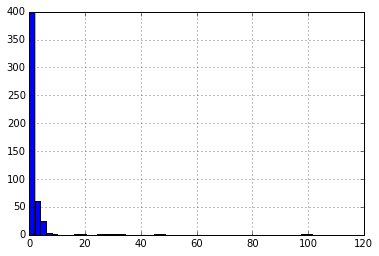

In [25]:
plt.hist(selector.scores_, bins=50, histtype='bar')
plt.grid()
plt.show()

In [26]:
variable_filter = selector.scores_ > 10
print ("Number of filtered variables: %i" % np.sum(variable_filter))
from sklearn.preprocessing import PolynomialFeatures
interactions = PolynomialFeatures(degree=2, interaction_only=True)
Xs = interactions.fit_transform(Xt[:,variable_filter])
print ("Number of variables and interactions: %i" % Xs.shape[1])

Number of filtered variables: 13
Number of variables and interactions: 92


In [27]:
logit.fit(Xs,yt)
Xvs = interactions.fit_transform(Xv[:,variable_filter])
print ('Validation area Under the Curve before recursive selection: %0.3f' % roc_auc_score(yv,logit.predict_proba(Xvs)[:,1]))

Validation area Under the Curve before recursive selection: 0.808


###Recursive feature selection

In [28]:
# Execution time: 3.15 s
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
lm = LinearRegression()
cv_iterator = KFold(n=len(X_train), n_folds=10, shuffle=True, random_state=101)
recursive_selector = RFECV(estimator=lm, step=1, cv=cv_iterator, scoring='mean_squared_error')
recursive_selector.fit(second_order.fit_transform(X_train),y_train)
print ('Initial number of features : %i' % second_order.fit_transform(X_train).shape[1])
print ('Optimal number of features : %i' % recursive_selector.n_features_)

Initial number of features : 105
Optimal number of features : 52


In [29]:
essential_X_train = recursive_selector.transform(second_order.fit_transform(X_train))
essential_X_test  = recursive_selector.transform(second_order.fit_transform(X_test))
lm.fit(essential_X_train, y_train)
print ('cases = %i features = %i' % essential_X_test.shape)
print ('In-sample  mean squared error %0.3f' % mean_squared_error(y_train,lm.predict(essential_X_train)))
print ('Out-sample mean squared error %0.3f' % mean_squared_error(y_test,lm.predict(essential_X_test)))

cases = 152 features = 52
In-sample  mean squared error 7.834
Out-sample mean squared error 11.523


In [30]:
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)
stratified_cv_iterator = StratifiedKFold(binning, n_folds=10, shuffle=True, random_state=101)
essential_X = recursive_selector.transform(second_order.fit_transform(X))
cv_score = cross_val_score(lm, essential_X, y, cv=stratified_cv_iterator, scoring='mean_squared_error', n_jobs=1)
print ('Cv score: mean %0.3f std %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score: mean 11.400 std 3.779


##Regularization

###Ridge

In [31]:
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
# The following commented line is to show a logistic regression with L2 regularization
# lr_l2 = LogisticRegression(C=1.0, penalty='l2', tol=0.01) 
ridge.fit(second_order.fit_transform(X), y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [32]:
lm.fit(second_order.fit_transform(X), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
print ('Average coefficient: Non regularized = %0.3f Ridge = %0.3f' % (np.mean(lm.coef_), np.mean(ridge.coef_)))
print ('Min coefficient: Non regularized = %0.3f Ridge = %0.3f' % (np.min(lm.coef_), np.min(ridge.coef_)))
print ('Max coefficient: Non regularized = %0.3f Ridge = %0.3f' % (np.max(lm.coef_), np.max(ridge.coef_)))

Average coefficient: Non regularized = 1.376 Ridge = -0.027
Min coefficient: Non regularized = -40.040 Ridge = -2.013
Max coefficient: Non regularized = 142.329 Ridge = 1.181


###Grid search for optimal parameters

In [34]:
from sklearn.grid_search import GridSearchCV
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)
stratified_cv_iterator = StratifiedKFold(binning, n_folds=10, shuffle=True, random_state=101)
search = GridSearchCV(estimator=ridge, param_grid={'alpha':np.logspace(-4,2,7)}, scoring = 'mean_squared_error', 
                      n_jobs=1, refit=True, cv=stratified_cv_iterator)
search.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % search.best_params_['alpha'])
print ('Best CV mean squared error: %0.3f' % np.abs(search.best_score_))

Best alpha: 0.00100
Best CV mean squared error: 11.883


In [35]:
search.grid_scores_

[mean: -12.45899, std: 5.32834, params: {'alpha': 0.0001},
 mean: -11.88307, std: 4.92960, params: {'alpha': 0.001},
 mean: -12.64747, std: 4.66278, params: {'alpha': 0.01},
 mean: -16.83243, std: 5.28501, params: {'alpha': 0.10000000000000001},
 mean: -22.91860, std: 5.95064, params: {'alpha': 1.0},
 mean: -37.81253, std: 8.63064, params: {'alpha': 10.0},
 mean: -66.65745, std: 10.35740, params: {'alpha': 100.0}]

In [36]:
# Alternative: sklearn.linear_model.RidgeCV
from sklearn.linear_model import RidgeCV
auto_ridge = RidgeCV(alphas=np.logspace(-4,2,7), normalize=True, scoring = 'mean_squared_error', cv=None)
auto_ridge.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % auto_ridge.alpha_)

Best alpha: 0.00100


## Random Search

In [37]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(estimator=ridge, param_distributions={'alpha':np.logspace(-4,2,100)}, n_iter=10, 
                               scoring='mean_squared_error', n_jobs=1, iid=False, refit=True, cv=stratified_cv_iterator)
search_func.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % search_func.best_params_['alpha'])
print ('Best CV mean squared error: %0.3f' % np.abs(search_func.best_score_))

Best alpha: 0.00046
Best CV mean squared error: 11.790


###Lasso

In [38]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0, normalize=True, max_iter=2*10**5)
#The following comment shows an example of L1 logistic regression
#lr_l1 = LogisticRegression(C=1.0, penalty='l1', tol=0.01)

In [39]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon
np.random.seed(101)
stratified_cv_iterator = StratifiedKFold(binning, n_folds=10, shuffle=True, random_state=101)
search_func=RandomizedSearchCV(estimator=lasso, param_distributions={'alpha':np.logspace(-5,2,100)}, n_iter=10, 
                               scoring='mean_squared_error', n_jobs=1, iid=False, refit=True, cv=stratified_cv_iterator)
search_func.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % search_func.best_params_['alpha'])
print ('Best CV mean squared error: %0.3f' % np.abs(search_func.best_score_))

Best alpha: 0.00006
Best CV mean squared error: 12.235


In [40]:
 print ('Zero value coefficients: %i out of %i' % (np.sum(~(search_func.best_estimator_.coef_==0.0)), 
                                                 len(search_func.best_estimator_.coef_)))

Zero value coefficients: 85 out of 105


In [41]:
# Alternative: sklearn.linear_model.LassoCV
# Execution time: 54.9 s
from sklearn.linear_model import LassoCV
auto_lasso = LassoCV(alphas=np.logspace(-5,2,100), normalize=True, n_jobs=1, cv=None, max_iter=10**6)
auto_lasso.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % auto_lasso.alpha_)

Best alpha: 0.01097


###Elasticnet

In [42]:
# Execution time: 1min 3s
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.15, normalize=True, max_iter=10**6, random_state=101)
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon
np.random.seed(101)
search_func=RandomizedSearchCV(estimator=elasticnet, param_distributions={'alpha':np.logspace(-5,2,100), 
                                'l1_ratio':np.arange(0.0, 1.01, 0.05)}, n_iter=10, 
                                scoring='mean_squared_error', n_jobs=1, iid=False, refit=True, cv=stratified_cv_iterator)
search_func.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % search_func.best_params_['alpha'])
print ('Best l1_ratio: %0.5f' % search_func.best_params_['l1_ratio'])
print ('Best CV mean squared error: %0.3f' % np.abs(search_func.best_score_))

Best alpha: 0.00002
Best l1_ratio: 0.60000
Best CV mean squared error: 11.900


In [43]:
 print ('Zero value coefficients: %i out of %i' % (np.sum(~(search_func.best_estimator_.coef_==0.0)), 
                                                 len(search_func.best_estimator_.coef_)))

Zero value coefficients: 102 out of 105


In [44]:
# Alternative: sklearn.linear_model.ElasticNetCV
from sklearn.linear_model import ElasticNetCV
auto_elastic = ElasticNetCV(alphas=np.logspace(-5,2,100), normalize=True, n_jobs=1, cv=None, max_iter=10**6)
auto_elastic.fit(second_order.fit_transform(X), y)
print ('Best alpha: %0.5f' % auto_elastic.alpha_)
print ('Best l1_ratio: %0.5f' % auto_elastic.l1_ratio_)

Best alpha: 0.01292
Best l1_ratio: 0.50000


##Stability selection

In [45]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [46]:
threshold = 0.03
stability_selection = RandomizedLogisticRegression(n_resampling=300, n_jobs=1, random_state=101, scaling=0.15, 
                                                   sample_fraction=0.50, selection_threshold=threshold)
interactions = PolynomialFeatures(degree=4, interaction_only=True)
model = make_pipeline(stability_selection, interactions, logit)
model.fit(Xt,yt)

Pipeline(steps=[('randomizedlogisticregression', RandomizedLogisticRegression(C=1, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=300,
               normalize=True, pre_dispatch='3*n_jobs', random_state=101,
               sample_fraction=0.5, scaling=0.15, selection...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [47]:
print ('Number of features picked by stability selection: %i' % np.sum(model.steps[0][1].all_scores_ >= threshold))

Number of features picked by stability selection: 19


In [48]:
from sklearn.metrics import roc_auc_score
print ('Area Under the Curve: %0.3f' % roc_auc_score(yv,model.predict_proba(Xv)[:,1]))

Area Under the Curve: 0.886
